
Module 2: ERA5 Precipitation Analysis for Shreveport, LA
This notebook analyzes daily total precipitation from ERA5 data using xarray and dask.

It identifies extreme precipitation days (95th percentile), computes composite and anomaly maps,
and visualizes results using matplotlib and cartopy.

Author: Nicholas Ruprecht
Date: September 27, 2025



In [1]:
# Packages 
import xarray as xr
import pandas as pd
import dask
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
# Shreveport, LA
city_lat, city_lon = 32.5, -93.75


In [3]:
# Precip Data from ERA-5
base_url = 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2022-12', freq='YS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)



In [4]:
#Referenced Lecture 4 to see files
file_list

['https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/1980/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1980010100_1980120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/1981/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1981010100_1981120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/1982/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1982010100_1982120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/1983/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1983010100_1983120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/1984/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1984010100_1984120100.nc',
 'https://osdf-data.gdex.ucar.edu/ncar/gdex/d633001/e5.moda.fc.sfc.accumu/1985/e5.moda.fc.sfc.accumu.128_228_tp.ll025s

In [5]:
#cached = [f"simplecache::{u}" for u in file_list]
ds = xr.open_mfdataset(
#    cached,
    file_list,
    engine="h5netcdf",         # or "h5netcdf"
    combine="by_coords",
    chunks={"time": 12},      # modest time chunks
    parallel=False,           # <- important: don't delay opens
  #  backend_kwargs={"storage_options": {"simplecache": {"cache_storage": "./_gdex_cache"}}},
)

In [6]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 528, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2022-12-01
Data variables:
    TP         (time, latitude, longitude) float32 2GB dask.array<chunksize=(12, 389, 776), meta=np.ndarray>
    utc_date   (time) int32 2kB dask.array<chunksize=(12,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper02 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Mon Nov 11 08:45:33 MST 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Nov 11 08:45:34 2019: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.7.9 (Homepage = http://n...

In [7]:
# ERA5 longitudes are 0 to 360, so convert -93.75 to 266.25
city_lon_era5 = 360 + city_lon  # = 266.25

# Select 5°x5° box
ds_box = ds['TP'].sel(
    latitude=slice(city_lat + 2.5, city_lat - 2.5),
    longitude=slice(city_lon_era5 - 2.5, city_lon_era5 + 2.5)
)

# Averaged over space to get daily time series
precip_ts = ds_box.mean(dim=['latitude', 'longitude'])


In [8]:
# Converted precipitation from meters to millimeters
precip_ts_mm = precip_ts * 1000
precip_95 = precip_ts_mm.quantile(0.95).compute()


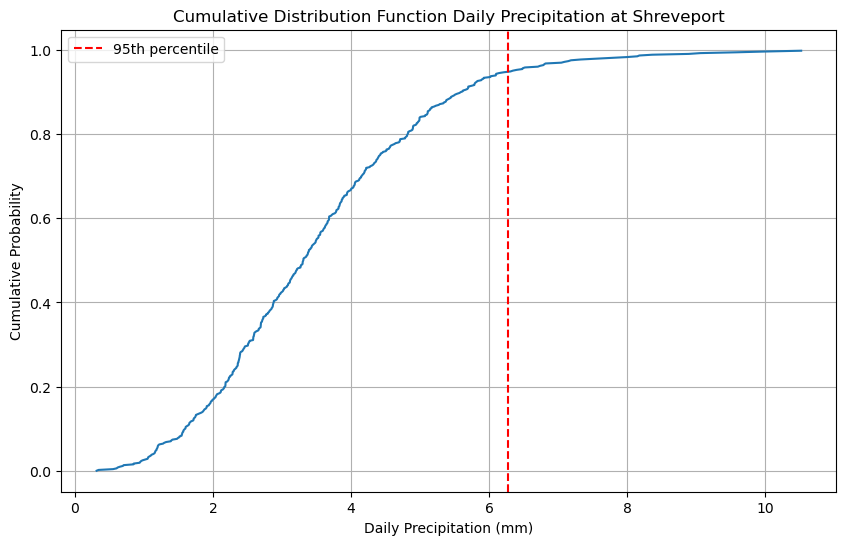

In [9]:
sorted_precip = np.sort(precip_ts_mm.values.flatten())
cdf = np.arange(len(sorted_precip)) / len(sorted_precip)

plt.figure(figsize=(10, 6))
plt.plot(sorted_precip, cdf)
plt.axvline(precip_95, color='red', linestyle='--', label='95th percentile')
plt.xlabel("Daily Precipitation (mm)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution Function Daily Precipitation at Shreveport")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
mask = (precip_ts_mm > precip_95).compute()

#  mask to extract the time values
extreme_days = precip_ts_mm['time'].where(mask, drop=True)


In [11]:
composite = ds['TP'].sel(time=extreme_days).mean(dim='time')
climatology = ds['TP'].sel(time=slice('1981-01-01', '2010-12-31')).mean(dim='time')

anomaly = composite - climatology

composite_mm = composite * 1000
anomaly_mm = anomaly * 1000



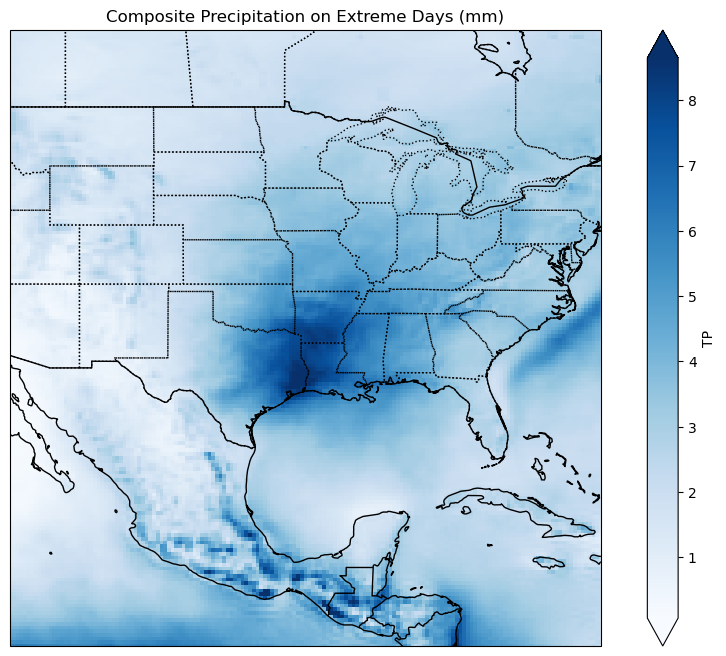

In [12]:
# Composite Graphic
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
composite_mm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', robust=True)
ax.set_extent([city_lon - 20, city_lon + 20, city_lat - 20, city_lat + 20])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_title("Composite Precipitation on Extreme Days (mm)")
plt.show()



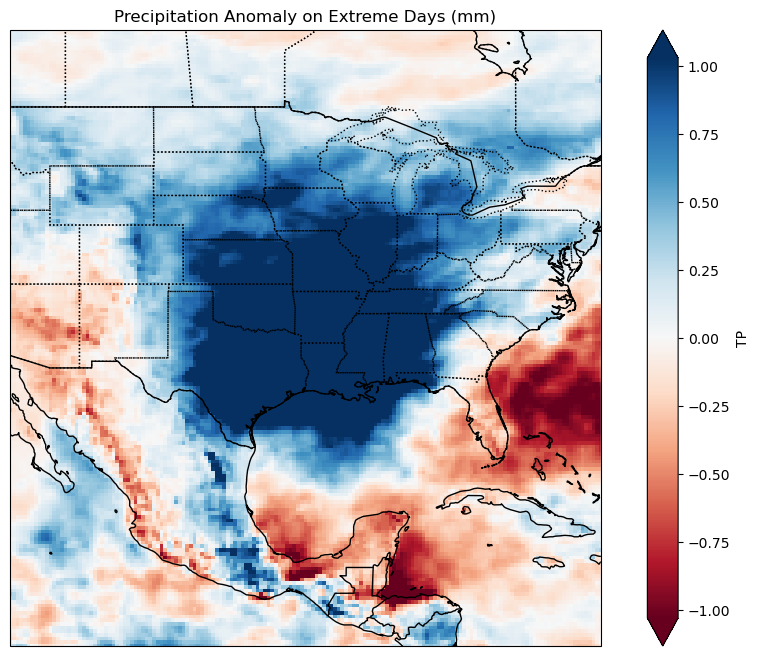

In [13]:
# Anomaly Graphic
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
anomaly_mm.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', robust=True)
ax.set_extent([city_lon - 20, city_lon + 20, city_lat - 20, city_lat + 20])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.set_title("Precipitation Anomaly on Extreme Days (mm)")
plt.show()



In [14]:
composite_mm.to_netcdf("composite_precip.nc")
anomaly_mm.to_netcdf("anomaly_precip.nc")


### Data Source
ERA5 Monthly Aggregated Forecast Surface Accumulated Precipitation  
Provided by NCAR GDEX (Geoscience Data Exchange)  
Accessed via: https://gdex.ucar.edu/  
Direct catalog link: https://tds.gdex.ucar.edu/thredds/catalog/files/g/d633001_nc/e5.moda.fc.sfc.accumu/1989/catalog.html  
DOI: https://doi.org/10.24381/cds.adbb2d47  

